In [15]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# neural network packages
import torch
import torch.utils
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
torch.manual_seed(0)

# data processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# to estimate the HAR model
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# own helping code
from utils.estimating import model_estimator, EarlyStopper
from utils.preprocessing import PreProcessor, data_to_loaders
from utils.functions import get_ticker_daily_close, print_nicely, reset_model_weights

# ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

### Process Data to Features and Targets Tensors

In [37]:
# LOAD DATA
# file_name = "msft_stock.csv"
# data = pd.read_csv("data/" + file_name)
# returns = data["price"].apply(np.log).diff()

# or through yahoo finance
prices = get_ticker_daily_close("PYPL")
returns = prices.apply(np.log).diff()
print(f"Total observations: {len(returns)}")

################################################################
# targets are just the squared returns
targets = returns ** 2

# features for neural network (lagged input)
df = pd.DataFrame({})
lags = 20
for i in range(1, lags+1):
    df[f"lag_{i}"] = targets.shift(i)

# features for HAR (realized daily/weekly/monthly volatility)
df_har = pd.DataFrame({})
df_har["rv_d"] = targets.shift(1)
df_har["rv_w"] = targets.rolling(5).apply(np.mean)
df_har["rv_m"] = targets.rolling(20).apply(np.mean)
    
# features and targets to numpy array
features_har = df_har.values
features = df.values
targets = targets.values.reshape(-1,1)

# this way we use the exact same features in the NN as in the HAR model
# can be changed ofcourse
features = features_har.copy()

# add constant for har features and drop nan values
features_har = sm.add_constant(features_har)

features_har = features_har[lags+1:-max(1, int(.3*lags))]
features = features[lags+1:-max(1, int(.3*lags))]
targets = targets[lags+1:-max(1, int(.3*lags))]

# final overview if features and targets
print(f"shape har featurs: {features_har.shape} of type {type(features_har)}")
print(f"shape nn features: {features.shape} of type {type(features)}")
print(f"shape targets: {targets.shape} of type {type(targets)}")

# split the data into the features set (used for cross validation and ultimately estimating the final model) and testing data
train_size = .8
features_har, features_har_validation, _placeholder, targets_validation = train_test_split(features_har, targets, shuffle=False, train_size = train_size)
features, features_validation, targets, targets_validation = train_test_split(features, targets, shuffle=False, train_size = train_size)

Total observations: 6358
shape har featurs: (6331, 4) of type <class 'numpy.ndarray'>
shape nn features: (6331, 3) of type <class 'numpy.ndarray'>
shape targets: (6331, 1) of type <class 'numpy.ndarray'>


### Define Neural Network
Here 2 neural networks are defined. The last one is now used in the estimation further on. A Recurrent neural network might be interesting to try out as well, due to its usually good performance on time series

In [38]:
class RecurrentNeuralNetwork(nn.Module):
    """ This class holds our model with 2 layers """
    def __init__(self, lags, hidden_dim = 1, n_layers = 1, output_size = 1):
        # initialize nn.Module
        super(RecurrentNeuralNetwork, self).__init__()
        
        # store model specifications
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # initialize layers
        self.rn = nn.RNN(lags, hidden_dim, n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x: torch.Tensor):
        """ feed forward a given input through 2 layers """
        x = x.unsqueeze(0)
        batch_size = x.size(0)
        
        hidden = self.init_hidden(batch_size)
        x, hidden = self.rn(x, hidden)
        x = x.contiguous().view(-1, self.hidden_dim)
        
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        
class RegularNN(nn.Module):
    """ This class holds our model with 2 layers """
    def __init__(self, input_size, hidden_nodes: int = 10, output_size = 1):
        # initialize nn.Module
        torch.manual_seed(3407)
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_nodes, bias = True)
        self.fc2 = nn.Linear(hidden_nodes, output_size, bias = True)

    def forward(self, x: torch.Tensor):
        """ feed forward a given input through 2 layers """             
        x = torch.flatten(x,1)
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

### Compare Neural Network VS HAR
A list of model specification can be given here.
There is a certain number of kfolds stepping through time (this is a must for time series cross validation).
The models are estimated on exactly the same data and for both the out of sample accuracy is computed.
The HAR model is estimated through regular OLS: Vol (1 day ahead) = constant + fac1 * Vol (1d) + fac2 * Vol (5d) + fac3 * Vol(20d)
The NN is estimated using Adam optimzer and MSE loss, with a specified learning rate.

In [39]:
def evaluate_model_kfolds(model_specification):
    kfold = TimeSeriesSplit(n_splits = 4, max_train_size = 7000, test_size = 500)
    model = RegularNN(input_size = 3, hidden_nodes = model_specification["hidden_nodes"], output_size = 1)
    
    i = 0
    for train_index, test_index in kfold.split(features):
        fit_evaluate_nn(model, train_index, test_index)
    
def fit_evaluate_nn(model, train_index, test_index):
    pass

In [40]:
plot = False

avg_scores = []
model_scores = []

for hidden_nodes in [2, 4, 7]:
    for lr in [0.0005, 0.001, 0.005, 0.01]:
        for epochs in [6]:
    
            #============================================================================================================================================================
            #============================================================================================================================================================
            #============================================================================================================================================================
            print_nicely(f"config: nodes-{hidden_nodes} lr-{lr} epochs-{epochs}", 100)
            
            # initialize model and kfolds
            kfold = TimeSeriesSplit(n_splits = 4, max_train_size = 7000, test_size = 500)
            model = RegularNN(input_size = 3, hidden_nodes = hidden_nodes, output_size = 1)
            
            score_nn = []

            i = 0
            for train_index, test_index in kfold.split(features):
                i += 1
                
                # reset model params
                reset_model_weights(model)
                
                # print(f"Estimating HAR and NN for kfold: {i}")
                
                # split data into feature and target data for NN
                features_train, features_test, targets_train, targets_test = features[train_index], features[test_index], targets[train_index], targets[test_index]
                features_train_har, features_test_har = features_har[train_index], features_har[test_index]
                
                # fit normalizer on train features and normalize data
                # print("Normalizing features ...")
                
                scaler = StandardScaler()
                features_train = scaler.fit_transform(features_train)
                features_test = scaler.transform(features_test)

                # all features and targets to float tensor
                features_train_tensor = torch.tensor(features_train, dtype=torch.float32)
                features_test_tensor = torch.tensor(features_test, dtype=torch.float32)
                targets_train_tensor = torch.tensor(targets_train, dtype=torch.float32)
                targets_test_tensor = torch.tensor(targets_test, dtype=torch.float32)
                
                # to dataloaders
                trainloader, testloader = data_to_loaders(features_train_tensor, features_test_tensor, targets_train_tensor, targets_test_tensor)
                        
                # initialize and estimate the model
                # print("Estimating NN model ...")
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr = lr)
                epochs = epochs
                
                model_estimator(
                    model,
                    optimizer, 
                    criterion, 
                    epochs=epochs,
                    trainloader=trainloader, 
                    testloader=testloader,
                    earlystopper=EarlyStopper(patience = 3, min_delta = 0))
                
                # perform out of sample prediction
                output = model(features_test_tensor)
                loss = criterion(output, targets_test_tensor)
                
                score_nn += [loss.item()]
                
                # print(f"NN out-of-sample loss: {loss}")

                if plot:
                    # plot prediction versus true daily volatility
                    fig, axs = plt.subplots(1,1, figsize = (15, 10))
                    ax.plot(output.detach().numpy(), label = "pred")
                    ax.plot(targets_test_tensor.detach().numpy(), label = "target")
                    for ax in axs:
                        ax.legend()
                        ax.grid()
                    plt.show()    

            avg_score_nn = np.average(score_nn)
            avg_scores += [avg_score_nn]
            print(f"Average NN MSE Loss: {avg_score_nn}")
            
            # model_scores += ["epochs": epochs, "hidden_nodes": hidden_nodes, "lr": lr})]
            model_scores += [(avg_score_nn, epochs, hidden_nodes, lr)]

# store the score with hyperparams in a dataframe, sort on lowest MSE and show
df_scores = pd.DataFrame(data = model_scores, columns = ["avg_score", "epochs", "hidden_nodes", "lr"])
df_scores = df_scores.sort_values(by="avg_score", ascending = True)
df_scores

=================================config: nodes-2 lr-0.0005 epochs-6=================================
Average NN MSE Loss: 3.821254557578868e-05
=================================config: nodes-2 lr-0.001 epochs-6==================================
Average NN MSE Loss: 4.253230095230265e-06
=================================config: nodes-2 lr-0.005 epochs-6==================================
Average NN MSE Loss: 2.3257535630705206e-07
==================================config: nodes-2 lr-0.01 epochs-6==================================
Early stopping due to no decrease in validation loss at epoch: 5
Early stopping due to no decrease in validation loss at epoch: 6
Average NN MSE Loss: 3.666159180681916e-07
=================================config: nodes-4 lr-0.0005 epochs-6=================================
Early stopping due to no decrease in validation loss at epoch: 5
Average NN MSE Loss: 0.00011880671407737964
=================================config: nodes-4 lr-0.001 epochs-6=================

,avg_score,epochs,hidden_nodes,lr
2,2.325754e-07,6,2,0.0050
10,3.336892e-07,6,7,0.0050
3,3.666159e-07,6,2,0.0100
11,5.725217e-07,6,7,0.0100
6,8.429085e-07,6,4,0.0050
7,1.414697e-06,6,4,0.0100
9,2.514666e-06,6,7,0.0010
1,4.253230e-06,6,2,0.0010
5,9.742048e-06,6,4,0.0010
0,3.821255e-05,6,2,0.0005


### Fit and Compare the Final Models

=================================Estimating HAR and NN for fold: 4==================================
Normalizing features ...
Estimating HAR model ...


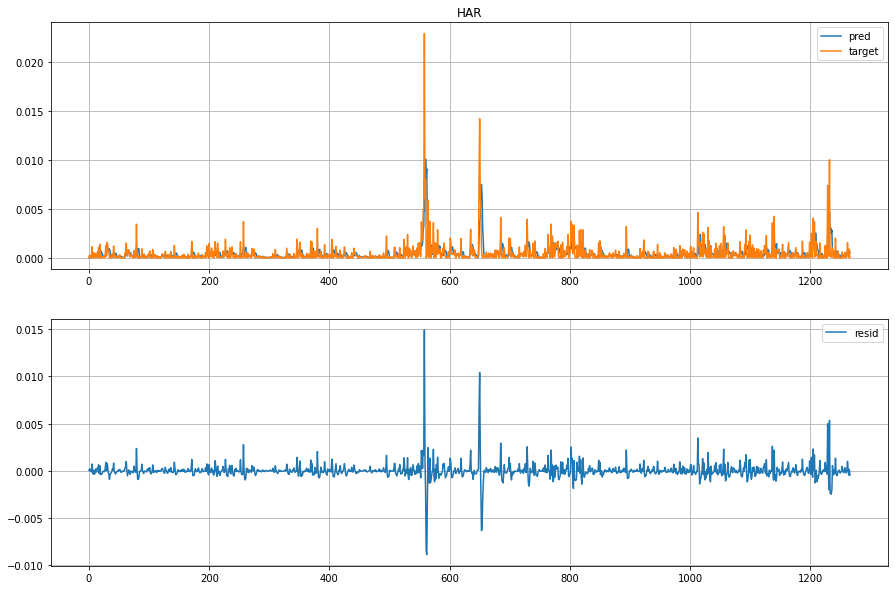

HAR out-of-sample loss: 1.8663000155528984e-06
Estimating NN model ...
NN out-of-sample loss: 1.3659230262419442e-06


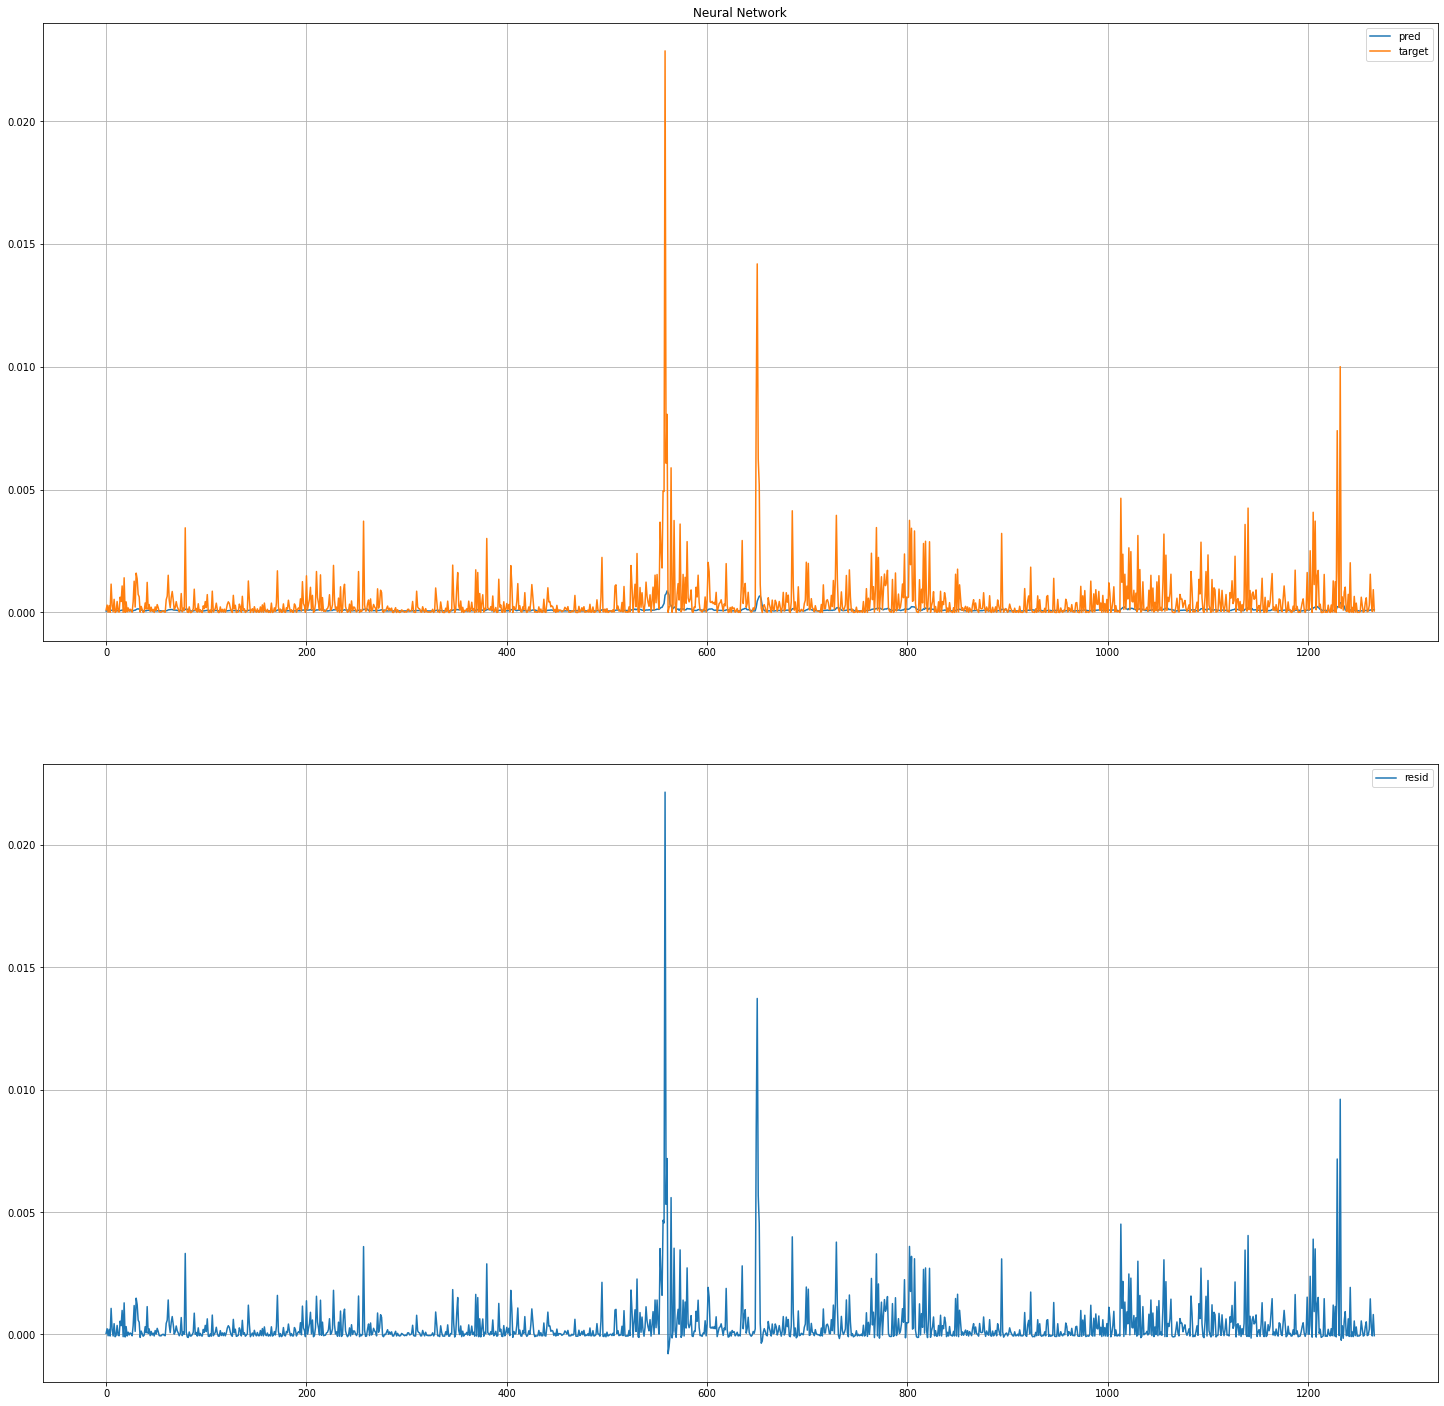

In [41]:
plot = True

# these params are taken from the extensive cross validations performed above
epochs = 6
hidden_nodes = 2
lr = 0.005

note = f"Estimating HAR and NN for fold: {i}"
print_nicely(note, 100)

# the available features
features_har, features, targets
features_har_validation, features_validation ,targets_validation

# fit normalizer on train features and normalize data
print("Normalizing features ...")
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

#=========================================================================================
#===================================ESTIMATE HAR==========================================
#=========================================================================================
print("Estimating HAR model ...")
mod = OLS(targets, features_har, hasconst = True)
mod = mod.fit()
output = mod.predict(features_har_validation)

loss = np.var(targets_validation - output)
score_har = loss

if plot:        
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (15, 10))
    axs[0].set_title("HAR")
    axs[0].plot(output, label = "pred")
    axs[0].plot(targets_validation, label = "target")
    axs[1].plot(targets_validation.reshape(-1,) - output, label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

print(f"HAR out-of-sample loss: {loss}")

#=========================================================================================
#====================================ESTIMATE NN==========================================
#=========================================================================================

# all features and targets to float tensor
features_train_tensor = torch.tensor(features, dtype=torch.float32)
features_test_tensor = torch.tensor(features_validation, dtype=torch.float32)
targets_train_tensor = torch.tensor(targets, dtype=torch.float32)
targets_test_tensor = torch.tensor(targets_validation, dtype=torch.float32)

trainloader, testloader = data_to_loaders(features_train_tensor, features_test_tensor, targets_train_tensor, targets_test_tensor)
        
# initialize and estimate the model
print("Estimating NN model ...")
model = RegularNN(3, hidden_nodes, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
epochs = epochs

model_estimator(
    model,
    optimizer, 
    criterion, 
    epochs=epochs,
    trainloader=trainloader, 
    testloader=testloader,
    earlystopper=None)

# perform out of sample prediction
output = model(features_test_tensor)
loss = criterion(output, targets_test_tensor)
score_nn = loss.item()

print(f"NN out-of-sample loss: {loss}")

if plot:
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (25,25))
    axs[0].set_title("Neural Network")
    axs[0].plot(output.detach().numpy(), label = "pred")
    axs[0].plot(targets_test_tensor.detach().numpy(), label = "target")
    axs[1].plot(targets_test_tensor.detach().numpy() - output.detach().numpy(), label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

#=========================================================================================
#=========================================================================================
#=========================================================================================